## 라이브러리 정의

In [53]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np

# 분석알고리즘 DecisinoTree 정의
from sklearn.tree import DecisionTreeRegressor

# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 함수
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

# 딥러닝에서 많이씀!
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 여기선 필요 X
from sklearn.ensemble import RandomForestClassifier

# 여기선 필요 X
from sklearn.linear_model import LinearRegression

## 데이터 불러오기

In [54]:
featureData = \
    pd.read_csv("../dataset/feature_regression_example.csv")
featureData.head(2)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201501,2015,1,1225,Y,1,Y,0.209442
1,SEOUL_BANK_001,PG02,PRODUCT0010,ITEM0115,201502,2015,2,968,N,4,Y,0.209442


## 1. 데이터 전처리
### 1-1. 타입 통합 / 특성 숫자컬럼 추가
#### 1-1-1. 데이터 타입 통합

In [55]:
featureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   REGIONID      105 non-null    object 
 1   PRODUCTGROUP  105 non-null    object 
 2   PRODUCT       105 non-null    object 
 3   ITEM          105 non-null    object 
 4   YEARWEEK      105 non-null    int64  
 5   YEAR          105 non-null    int64  
 6   WEEK          105 non-null    int64  
 7   QTY           105 non-null    int64  
 8   HOLIDAY       105 non-null    object 
 9   HCLUS         105 non-null    int64  
 10  PROMOTION     105 non-null    object 
 11  PRO_PERCENT   105 non-null    float64
dtypes: float64(1), int64(5), object(6)
memory usage: 10.0+ KB


In [56]:
#주으할 사항은 모든 컬럼에 대해서 고정시키는 걸 고려하는게 나을 수도 있다.
featureData.QTY = featureData.QTY.astype(float)

#### 1-1-2. 특성 값 숫자컬럼 변경

이유 : 머신러닝 특성은 숫자형 지원
 - 해결 Y+1, N+0과 같이 변환

In [10]:
# LabelEncoder를 이용하면 편리. 내가 Y N안해줘도 만들어줌.
holiEn = LabelEncoder()

In [11]:
featureData["HOLIDAY_LABEL_EN"] = holiEn.fit_transform(featureData.HOLIDAY)

In [12]:
featureData.HOLIDAY_LABEL_EN

0      1
1      0
2      0
3      1
4      0
      ..
100    1
101    0
102    0
103    0
104    1
Name: HOLIDAY_LABEL_EN, Length: 105, dtype: int32

In [9]:
# 디코딩도 가능
featureData["HOLIDAY_DE"] = \
    holiEn.inverse_transform(featureData.HOLIDAY_LABEL_EN)

In [10]:
featureData.columns

Index(['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT',
       'HOLIDAY_LABEL_EN', 'HOLIDAY_DE'],
      dtype='object')

In [11]:
featureData.dtypes

REGIONID             object
PRODUCTGROUP         object
PRODUCT              object
ITEM                 object
YEARWEEK              int64
YEAR                  int64
WEEK                  int64
QTY                 float64
HOLIDAY              object
HCLUS                 int64
PROMOTION            object
PRO_PERCENT         float64
HOLIDAY_LABEL_EN      int32
HOLIDAY_DE           object
dtype: object

In [57]:
# np.where을 쓰든 loc function을 쓰든
featureData["HOLIDAY_NEW"] = \
    np.where(featureData.HOLIDAY=="Y",1,0)

In [58]:
# np.where을 쓰든 loc function을 쓰든
featureData["PROMOTION_NEW"] = \
    np.where(featureData.PROMOTION=="Y",1,0)

In [59]:
featureData.HOLIDAY.drop_duplicates()

0    Y
1    N
Name: HOLIDAY, dtype: object

In [60]:
#pd.DataFrame( featureData.HOLIDAY.drop_duplicates() ).reset_index().\
#    rename(columns={"index":"HOLIDAY_NEW"})

### 1-2. 특성 선정 / 데이터 분리

In [61]:
# 상관계수
corrDf = featureData.corr()

In [62]:
standardLimit = 0.5

In [63]:
corrDf.loc[( abs(corrDf.QTY) > standardLimit) & (corrDf.QTY != 1)]

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
HCLUS,-0.071586,0.028593,-0.339943,-0.537230,1.000000,-0.545619,-0.974601,-0.374072
PRO_PERCENT,0.404889,0.321193,0.329705,0.700195,-0.545619,1.000000,0.487062,0.898554
HOLIDAY_NEW,0.049867,-0.031106,0.273710,0.505932,-0.974601,0.487062,1.000000,0.365148
PROMOTION_NEW,0.205916,0.195931,0.060206,0.612451,-0.374072,0.898554,0.365148,1.000000


In [64]:
features = \
    list(corrDf.loc[( abs(corrDf.QTY) > standardLimit) & (corrDf.QTY != 1)].index )

In [65]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'PROMOTION_NEW']

In [66]:
# 정답지는 바뀌지 않으므로 하드코딩 해도됨
# 사실 하드코딩은 무조건 안됨. DB랑 연동해야함!
label = ["QTY"]

### 1-2-2. 데이터 분리

In [67]:
standardIndex = 0.8

In [68]:
# 105개의 행, 14개의 컬럼
featureData.shape

(105, 14)

In [69]:
sortKey = ["REGIONID", "ITEM", "YEARWEEK"]

In [70]:
sortedData = featureData.sort_values(sortKey, ignore_index=True)

In [71]:
# 정렬하고 80%에 있는 인덱스의 번호로 분리시킨다!
selectedIndex = int( list( sortedData.shape)[0] * standardIndex)

In [72]:
yearweekStd = sortedData.loc[selectedIndex].YEARWEEK

In [73]:
yearweekStd

201632

In [74]:
# 훈련데이터와 테스트데이터를 (문제지와 정답지로 구분해서 정의한다.)
trainingDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, features]
trainingDataLabel = \
    sortedData.loc[sortedData.YEARWEEK <= yearweekStd, label]
testDataFeatures = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, features]
testDataLabel = \
    sortedData.loc[sortedData.YEARWEEK > yearweekStd, label]

In [75]:
# 기계에다가 학습시킬 훈련 데이터는 이게 된다!
trainingDataFeatures

,HCLUS,PRO_PERCENT,HOLIDAY_NEW,PROMOTION_NEW
0,1,0.209442,1,1
1,4,0.209442,0,1
2,4,0.208155,0,1
3,2,0.208155,1,1
4,4,0.208155,0,1
...,...,...,...,...
80,1,0.308584,1,1
81,1,0.308584,1,1
82,4,0.280258,0,1
83,4,0.280258,0,1


## 2. 모델적용

### 2-1. 모델 적용

#### 2-1-1. 학습

In [76]:
# 하이퍼 파라미터 튜닝 (분석가가 가장 많이 하는 일 중 하나)
# 모델선언
model_dt = DecisionTreeRegressor(random_state=10)
model_rf = RandomForestRegressor(random_state=10)

In [77]:
# x는 문제지, y는 정답지
# 학습은 이 2줄로 끝난다!
model_dt.fit(X=trainingDataFeatures, y=trainingDataLabel)
model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)

RandomForestRegressor(random_state=10)

## 3. 예측

In [78]:
# graphviz로 다 뜯어볼 수 있다
# explainable ai
predictValueDt = model_dt.predict(testDataFeatures)
predictValueRf = model_rf.predict(testDataFeatures)

In [79]:
testDataAll = \
    featureData.loc[ testDataFeatures.index ] 

In [80]:
predictDtDf = \
    pd.DataFrame(list(predictValueDt) , columns=["PREDICT_DT"])
predictRfDf = \
    pd.DataFrame(list(predictValueRf) , columns=["PREDICT_RF"])

In [81]:
predictDtDf.head()

,PREDICT_DT
0,350.714286
1,1434.600000
2,1434.600000
3,1434.600000
4,1434.600000


In [82]:
predictRfDf.head()

,PREDICT_RF
0,353.535465
1,1409.048303
2,1409.048303
3,1409.048303
4,1439.099008


### 4. 데이터 정리

In [83]:
testDataLabel.head()

,QTY
85,43.0
86,1700.0
87,1514.0
88,1501.0
89,1491.0


In [84]:
validateDf = \
    pd.concat( [testDataLabel.reset_index(drop=True), predictDtDf, predictRfDf], axis=1)

In [85]:
validateDf.head()

,QTY,PREDICT_DT,PREDICT_RF
0,43.0,350.714286,353.535465
1,1700.0,1434.600000,1409.048303
2,1514.0,1434.600000,1409.048303
3,1501.0,1434.600000,1409.048303
4,1491.0,1434.600000,1439.099008


## 5. 정확도 검증

In [86]:
mae = mean_absolute_error(y_true=validateDf.QTY,
                    y_pred=validateDf.PREDICT_DT)

In [87]:
rmse = np.sqrt( mean_squared_error(y_true=validateDf.QTY,
                    y_pred=validateDf.PREDICT_DT) )

In [88]:
mae

398.78035714285716

In [89]:
rmse

471.29147199910335

In [91]:
# DecisionTree
# 장점 : 과거의 경험치를 그대로 반영한다~ 
#       변동성이 큰 데이터에서 강하다~

# 단점
# 오버피팅! (너무 과거에 얽매임)

# randomforest
# 장점 : DecisionTree의 오버피팅을 해결~
# 단점 : 설명력이 좀 어렵다~

In [92]:
features

['HCLUS', 'PRO_PERCENT', 'HOLIDAY_NEW', 'PROMOTION_NEW']

In [93]:
userInputHCLUS = 1
userInputProPercent = 0.5
userInputHolidayYn = 1
userInputPromotionYn = 1

futureData = pd.DataFrame([[ userInputHCLUS,
              userInputProPercent,
              userInputHolidayYn,
              userInputPromotionYn ]] )

# pickle 파일로 저장가능
model_dt.predict(futureData)

array([1434.6])

In [95]:
import pickle

In [47]:
filename = 'finalized_model.sav'
pickle.dump(model_dt, open(filename, 'wb'))

In [48]:
# 데이터 처리 라이브러리
import pandas as pd
import numpy as np
# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor 
# 과거데이터를 8:2, 7:3 이나 이런식으로 자동으로 나누어주는 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import sys

import pickle

loadedModel= "finalized_model.sav"

loaded_model2 = pickle.load(open(loadedModel, 'rb'))

loaded_model2

userInputHCLUS = 1
userInputProPercent=0.5
userInputHoilidayYn = 1
userInputPromotionYn = 1

futureData = pd.DataFrame([[ userInputHCLUS,
              userInputProPercent,
              userInputHoilidayYn,
              userInputPromotionYn]]   )

# pickle 파일로 저장가능하다.


print(loaded_model2.predict(futureData))


[1434.6]


### graphviz 테스트용

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dt_clf = DecisionTreeClassifier()

iris_data = load_iris()
X_train , X_test , y_train , y_test = train_test_split(iris_data.data, iris_data.target, test_size=0.2)

dt_clf.fit(X_train , y_train)

DecisionTreeClassifier()

In [50]:
from sklearn.tree import export_graphviz

# tree.dot 파일 생성
export_graphviz(dt_clf, out_file="tree.dot", class_names=iris_data.target_names, feature_names=iris_data.feature_names, impurity=True, filled=True)

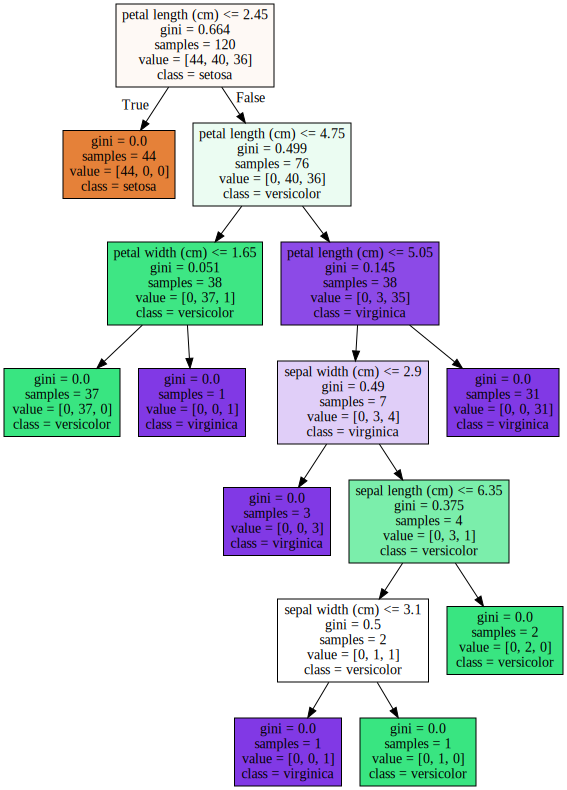

In [51]:
import graphviz

# tree.dot 파일을 Graphviz로 읽어 Jupyter Notebook에서 시각화 
with open("tree.dot") as f:
    dot_graph = f.read()
src = graphviz.Source(dot_graph)
src